#### Time series data manipulation in pandas

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

 - pd.Timestamp
 - pd.date_range
 - pd.to_datetime

In [2]:
# Create the range of dates here
seven_days = pd.date_range(start='2017-1-1',periods=7)

# Iterate over the dates and print the number and name of the weekday
for day in seven_days:
    print(day.dayofweek, day.day_name())

6 Sunday
0 Monday
1 Tuesday
2 Wednesday
3 Thursday
4 Friday
5 Saturday


In [3]:
etfs = pd.read_csv('ml/ml_assets/etfs.csv',index_col='Dates')
etfs.index = pd.to_datetime(etfs.index)
swda = etfs[['SWDA']]

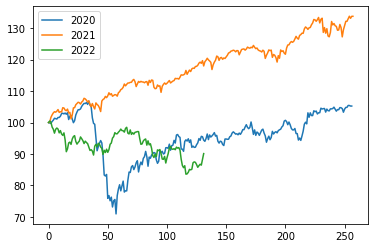

In [4]:
# Create dataframe prices here
prices = pd.DataFrame()

# Select data for each year and concatenate with prices here 
for year in ['2020', '2021','2022']:
    price_per_year = swda.loc[year, ['SWDA']].reset_index(drop=True)
    price_per_year.rename(columns={'SWDA': year}, inplace=True)
    prices = pd.concat([prices, price_per_year], axis=1)

# Plot normalized prices
prices.div(prices.loc[0]).mul(100).plot()
plt.show()

In [5]:
prices

,2020,2021,2022
0,56.71,59.31,79.16
1,56.63,59.38,79.53
2,56.54,60.27,79.27
3,56.90,60.74,78.03
4,57.13,61.12,77.49
...,...,...,...
253,59.79,78.89,NaN
254,59.78,79.35,NaN
255,59.68,78.96,NaN
256,59.68,79.34,NaN


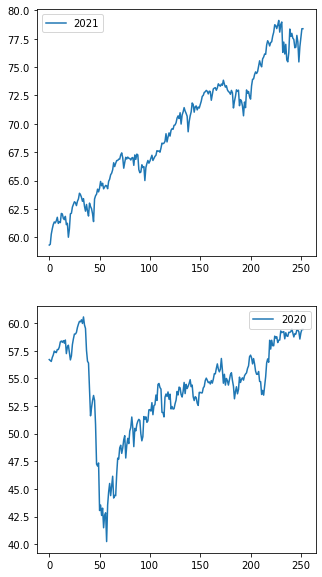

In [6]:
# Plot the time series in each dataset
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
prices.loc[:252].plot(y='2021', ax=axs[0])
prices.loc[:252].plot(y='2020', ax=axs[1])
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2019-07-30 to 2022-07-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SWDA    756 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB
None


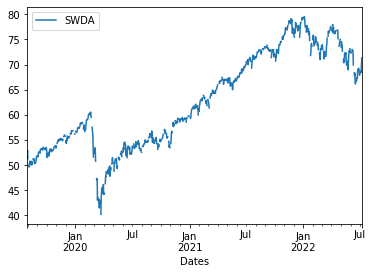

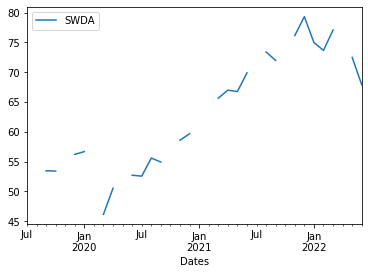

In [7]:
# Inspect data
print(swda.info())

# Set data # set the frequency to calendar daily
swda.asfreq('D').plot(subplots=True)
plt.show()

# Set frequency to monthly
swda.asfreq('M').plot(subplots=True)
plt.show()


#### Random walk

 - using numpy and scipy
 - compare random walk with asset returns

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


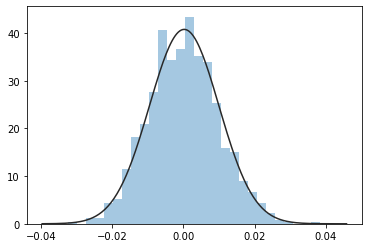

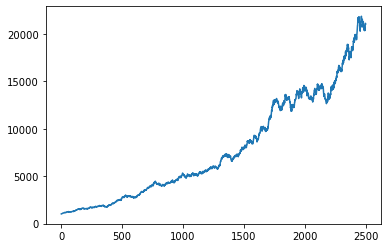

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


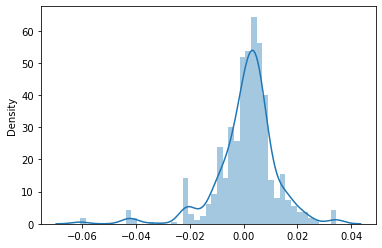

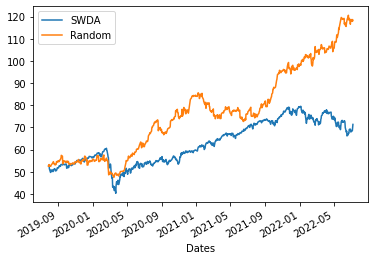

In [113]:
from numpy.random import normal, seed, choice
from scipy.stats import norm
import seaborn as sns

seed(42)

random_returns = normal(loc=0, scale=0.01, size=1000)
sns.distplot(random_returns, fit=norm, kde=False)
plt.show()

# Create random_walk
random_walk = normal(loc=.001, scale=0.01, size=2500)

# Create random_prices
random_prices = pd.Series(random_walk).add(1).cumprod()

# Plot random_prices here
random_prices.mul(1000).plot()
plt.show()


# Calculate daily_returns here
daily_returns = swda.pct_change().dropna()

# Get n_obs
n_obs = daily_returns.count()[0]

# Create random_walk
random_walk = choice(daily_returns.values.ravel(), size=n_obs)

# Convert random_walk to pd.series
random_walk = pd.Series(random_walk, index = daily_returns.index)

# Plot random_walk distribution
sns.distplot(random_walk)
plt.show()

swda['Random'] = random_walk.add(1)
swda.iloc[0,1] = swda.iloc[0,0].copy()
swda['Random'] = swda['Random'].cumprod()
swda.plot()
plt.show()

#### Time series analysis

 - autocorrelation
 - white noise
 - random walk
 - AR model
 - MA model
 - ARMA model
 - ARIMA model

1. autocorrelation

 - null hypothesis is that our correlation at lag k, rk, is equal to zero at the 5% level
 - alpha = 5% means there's a 5% chance that if the true autocorrelation is 0 it falls outside the band
 - we have evidence to reject the null if values fall outside the band
 - but beware we should expect 5% of these lags to exceed these values anyway
 - further we are displaying correlated values and hence if one lag falls outside of these boundaries then proximate sequential values are more likely to do so as well
 - in practice we are looking for lags that may have some underlying reason for exceeding the 5% level
 - even if the true autocorrelations were zero at all lags, in a finite sample of returns you won't see the estimate of the autocorrelations exactly zero. In fact, the standard deviation of the sample autocorrelation is 1/N where N is the number of observations, so if N = 100, for example, the standard deviation of the ACF is 0.1, and since 95% of a normal curve is between +1.96 and -1.96 standard deviations from the mean, the 95% confidence interval is ±1.96/N. This approximation only holds when the true autocorrelations are all zero.

The autocorrelation of returns is -0.05
The approximate confidence interval is +/- 0.33

 [ 1.         -0.04499046 -0.16436617 -0.04057022  0.19759938 -0.0291837
 -0.19551148  0.34890656 -0.13510199 -0.0376401  -0.1210332   0.0475642
 -0.08562517 -0.09821601 -0.03358353 -0.12417783]


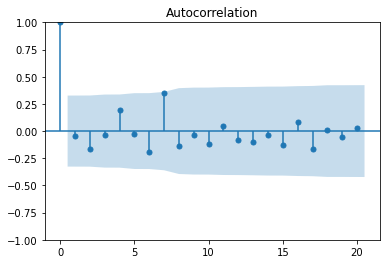

In [103]:
# Import the plot_acf module from statsmodels and sqrt from math
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt

# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf


# Resample
swda.index = pd.to_datetime(swda.index)
ret_swda = swda.SWDA.resample(rule='M').last().pct_change().dropna()

# Compute and print the autocorrelation
autocorrelation = ret_swda.autocorr()
print("The autocorrelation of returns is %4.2f" %(autocorrelation))

# Find the number of observations by taking the length of the returns DataFrame
nobs = len(ret_swda)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))


# Compute the acf array
acf_array = acf(ret_swda)
print('\n',acf_array)

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(ret_swda, alpha=0.05, lags=20)
plt.show()

# Plot the acf function without bands
# plot_acf(ret_swda, alpha=1)
# plt.show()

2. White noise

 - any process with constant mean, constant variance and zero autocorrelations at all lags (e.g. discrete white noise = process with mean equal to zero, variance equal to σ^2 and no serial correlation)
 - Gaussian white noise = process where the data has a normal distribution
 - in particular, if the values wt are drawn from a standard normal distribution (i.e. wt ∼ N (0, σ^2)), then the series is known as Gaussian white noise

The mean is 0.017 and the standard deviation is 0.050


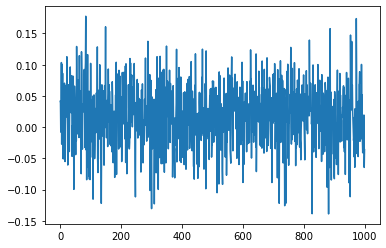

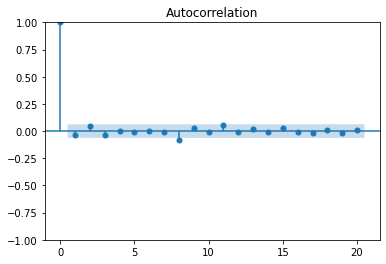

In [116]:
# Simulate white noise returns
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)

# Print out the mean and standard deviation of returns
mean = np.mean(returns)
std = np.std(returns)
print("The mean is %5.3f and the standard deviation is %5.3f" %(mean,std))

# Plot returns series
plt.plot(returns)
plt.show()

# Plot autocorrelation function of white noise returns
plot_acf(returns, lags=20)
plt.show()